# 1. Import Packages

In [67]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.io as pio
import re
from scipy.stats import spearmanr, kendalltau, chi2_contingency, stats, f_oneway
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2. Data Loading

In [ ]:
# Membuat BigQuery client
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/User/Downloads/pip-hacktiv-64e793184abb.json"
client = bigquery.Client()

# Query untuk load public dataset
query = """
WITH order_data AS (
  SELECT 
    order_id,
    user_id,
    status,
    created_at,
    shipped_at,
    delivered_at,
    returned_at,
    num_of_item
  FROM 
    `bigquery-public-data.thelook_ecommerce.orders`
  WHERE 
    created_at BETWEEN '2023-01-01' AND '2023-06-30'
),

order_item_data AS (
  SELECT 
    id AS order_item_id,
    order_id,
    user_id,
    product_id,
    inventory_item_id,
    status,
    created_at,
    shipped_at,
    delivered_at,
    returned_at,
    sale_price
  FROM 
    `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE 
    created_at BETWEEN '2023-01-01' AND '2023-06-30'
),

inventory_item_data AS (
  SELECT 
    id AS inventory_item_id,
    product_id,
    created_at,
    sold_at,
    cost,
    product_category,
    product_name,
    product_brand,
    product_retail_price,
    product_department,
    product_sku
  FROM 
    `bigquery-public-data.thelook_ecommerce.inventory_items`
),

product_data AS (
  SELECT 
    id AS product_id,
    cost,
    category,
    name,
    brand,
    retail_price,
    department,
    sku,
    distribution_center_id
  FROM 
    `bigquery-public-data.thelook_ecommerce.products`
),

distribution_center_data AS (
  SELECT 
    id AS distribution_center_id,
    name AS distribution_center_name,
    latitude,
    longitude
  FROM 
    `bigquery-public-data.thelook_ecommerce.distribution_centers`
)

SELECT 
  od.order_id,
  od.status AS order_status,
  od.created_at AS order_created,
  od.shipped_at AS order_shipped,
  od.delivered_at AS order_delivered,
  od.num_of_item,
  
  oid.order_item_id,
  oid.sale_price,
  oid.status AS order_item_status,
  
  iid.inventory_item_id,
  iid.product_category,
  iid.product_name,
  iid.cost AS product_cost,
  
  pd.product_id,
  pd.brand,
  pd.retail_price,
  pd.department,
  
  dc.distribution_center_id,
  dc.distribution_center_name,

FROM 
  order_data od
JOIN 
  order_item_data oid ON od.order_id = oid.order_id
JOIN 
  inventory_item_data iid ON oid.inventory_item_id = iid.inventory_item_id
JOIN 
  product_data pd ON oid.product_id = pd.product_id
JOIN 
  distribution_center_data dc ON pd.distribution_center_id = dc.distribution_center_id

ORDER BY 
  od.created_at;
"""

# Menyimpan hasil query kedalam dataframe
df = client.query(query).to_dataframe()

# Save ke CSV
df.to_csv('dataset.csv', index=False)

# 3. Problem Statement

## 3.1 Problem Background

Dalam penjualan, pembatalan (Cancelled) dan pengembalian (Returned) adalah indikator penting untuk mengevaluasi kinerja operasional dan kepuasan pelanggan. Persentase pembatalan dan pengembalian yang tinggi dapat menunjukkan beberapa masalah seperti:

- Kinerja supply chain yang tidak optimal:

- Masalah kualitas produk atau ketidaksesuaian ekspektasi pelanggan:

- Dampak finansial yang signifikan:

Oleh karena itu, penting untuk memahami pola pembatalan dan pengembalian ini untuk memperbaiki efisiensi operasional, meningkatkan layanan pelanggan, dan mengurangi biaya operasional.

## 3.2 SMART

Specific: Analisis pesanan berstatus cancel dan returned untuk memahami pola dan penyebab utama. <br>

Measurable: Mengukur proporsi pesanan cancel dan returned terhadap total pesanan, kerugian finansial, dan identifikasi produk bermasalah.<br>

Achievable: Data yang tersedia memungkinkan untuk mengevaluasi pola pembatalan dan pengembalian berdasarkan waktu, produk, dan lokasi.<br>

Relevant: Fokus pada pengurangan jumlah cancel dan returned untuk meningkatkan efisiensi operasional dan pengalaman pelanggan.<br>

Time-bound: Analisis mencakup periode Q1-Q2 2023 dan akan diselesaikan dalam waktu 2 minggu.

# 4. Data Info

In [ ]:
# Cek data
df.head(5)

,order_id,order_status,order_created,order_shipped,order_delivered,num_of_item,order_item_id,sale_price,order_item_status,inventory_item_id,product_category,product_name,product_cost,product_id,brand,retail_price,department,distribution_center_id,distribution_center_name
0,31422,Returned,2023-01-01 01:28:00+00:00,2023-01-03 10:58:00+00:00,2023-01-07 16:42:00+00:00,1,45531,34.950001,Returned,122949,Accessories,Beardski Pirate Ski Mask,14.50425,28383,Beardski,34.950001,Men,7,Philadelphia PA
1,20285,Complete,2023-01-01 01:40:00+00:00,2023-01-01 22:24:00+00:00,2023-01-02 22:56:00+00:00,4,29294,142.500000,Complete,79161,Jeans,Diesel Men's Larkee 886T Relaxed Straight-Leg ...,69.25500,21243,Diesel,142.500000,Men,10,Savannah GA
2,20285,Complete,2023-01-01 01:40:00+00:00,2023-01-01 22:24:00+00:00,2023-01-02 22:56:00+00:00,4,29297,148.000000,Complete,79170,Sweaters,Armani Exchange Quilted Zip Cardigan,72.96400,19265,A:X Armani Exchange,148.000000,Men,8,Mobile AL
3,20285,Complete,2023-01-01 01:40:00+00:00,2023-01-01 22:24:00+00:00,2023-01-02 22:56:00+00:00,4,29296,25.000000,Complete,79167,Swim,Gotcha Men's Busy Plaid Boardshort,15.00000,28213,Gotcha,25.000000,Men,5,New Orleans LA
4,20285,Complete,2023-01-01 01:40:00+00:00,2023-01-01 22:24:00+00:00,2023-01-02 22:56:00+00:00,4,29295,54.000000,Complete,79164,Swim,Rufskin - Buzio - Brazilian Mesh Sunga - White...,33.10200,27916,Rufskin,54.000000,Men,1,Memphis TN


In [ ]:
# Cek data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18609 entries, 0 to 18608
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   order_id                  18609 non-null  Int64              
 1   order_status              18609 non-null  object             
 2   order_created             18609 non-null  datetime64[us, UTC]
 3   order_shipped             12109 non-null  datetime64[us, UTC]
 4   order_delivered           6403 non-null   datetime64[us, UTC]
 5   num_of_item               18609 non-null  Int64              
 6   order_item_id             18609 non-null  Int64              
 7   sale_price                18609 non-null  float64            
 8   order_item_status         18609 non-null  object             
 9   inventory_item_id         18609 non-null  Int64              
 10  product_category          18609 non-null  object             
 11  product_name   

In [5]:
df.describe()

,order_id,num_of_item,order_item_id,sale_price,inventory_item_id,product_cost,product_id,retail_price,distribution_center_id
count,18609.0,18609.0,18609.0,18609.000000,18609.0,18609.000000,18609.0,18609.000000,18609.0
mean,62315.216025,1.893869,90317.351658,59.436541,243804.179805,28.576612,15228.884679,59.436541,5.001182
std,36361.800158,1.061961,52722.934942,66.158778,142362.375312,30.670483,8415.787536,66.158778,2.909276
min,3.0,1.0,3.0,1.510000,8.0,0.644770,1.0,1.510000,1.0
25%,30390.0,1.0,44052.0,24.500000,118924.0,11.382600,8004.0,24.500000,2.0
50%,62496.0,2.0,90597.0,39.990002,244369.0,19.656960,15906.0,39.990002,5.0
75%,93914.0,2.0,136145.0,69.870003,367444.0,34.511402,22555.0,69.870003,8.0
max,124742.0,4.0,180641.0,999.000000,487849.0,557.151002,29120.0,999.000000,10.0


# 5. Exploratory Data Analysis (EDA)

In [6]:
df.duplicated().sum()

0

Tidak terdapat data duplikat dalam dataset ini

## 5.1 Cardinality Check

In [7]:
# Cardinality check for client_data
def check_unique_values(data):
    for column in data.columns:
        unique_values = data[column].unique()
        print(f'Column: {column}')
        print(f'Unique value count: {len(unique_values)}')
        print(f'Unique value: {unique_values}\n')

check_unique_values(df)

Column: order_id
Unique value count: 12875
Unique value: <IntegerArray>
[ 31422,  20285,  44423,  86093,  64101,  34842, 121747,  67436,  66647,
  19721,
 ...
 107709,  27954, 122059,  42925,  86170,  70540,  78080,   6499,  33619,
  94447]
Length: 12875, dtype: Int64

Column: order_status
Unique value count: 5
Unique value: ['Returned' 'Complete' 'Shipped' 'Cancelled' 'Processing']

Column: order_created
Unique value count: 12467
Unique value: <DatetimeArray>
['2023-01-01 01:28:00+00:00', '2023-01-01 01:40:00+00:00',
 '2023-01-01 01:44:00+00:00', '2023-01-01 02:02:00+00:00',
 '2023-01-01 02:35:00+00:00', '2023-01-01 03:35:00+00:00',
 '2023-01-01 03:53:00+00:00', '2023-01-01 04:12:00+00:00',
 '2023-01-01 04:39:00+00:00', '2023-01-01 05:12:00+00:00',
 ...
 '2023-06-29 15:39:00+00:00', '2023-06-29 15:45:00+00:00',
 '2023-06-29 16:00:00+00:00', '2023-06-29 16:02:00+00:00',
 '2023-06-29 16:11:00+00:00', '2023-06-29 16:31:00+00:00',
 '2023-06-29 16:49:00+00:00', '2023-06-29 17:06:00+00:00',

## 5.2 Handling Missing Value

### 5.2.1 Missing Value for order_shipped dan order_delivered

In [8]:
# Cek jumlah NaN di kolom shipped dan delivered
print("Jumlah NaN di order_shipped:")
print(df['order_shipped'].isna().sum())
print("\nJumlah NaN di order_delivered:")
print(df['order_delivered'].isna().sum())

# Distribusi status order item
print("\nDistribusi Order Item Status:")
print(df['order_item_status'].value_counts())

# Persentase NaN di shipped dan delivered untuk setiap status
def nan_percentage(series):
    return series.isna().sum() / len(series) * 100

nan_analysis = df.groupby('order_item_status').agg({
    'order_shipped': nan_percentage,
    'order_delivered': nan_percentage
})
print("\nPersentase NaN di Shipped dan Delivered untuk setiap Status:")
print(nan_analysis)

Jumlah NaN di order_shipped:
6500

Jumlah NaN di order_delivered:
12206

Distribusi Order Item Status:
order_item_status
Shipped       5706
Complete      4611
Processing    3745
Cancelled     2755
Returned      1792
Name: count, dtype: int64

Persentase NaN di Shipped dan Delivered untuk setiap Status:
                   order_shipped  order_delivered
order_item_status                                
Cancelled                  100.0            100.0
Complete                     0.0              0.0
Processing                 100.0            100.0
Returned                     0.0              0.0
Shipped                      0.0            100.0


In [9]:
# Fungsi untuk mengisi nilai 'order_shipped'
def fill_order_shipped(row):
    if pd.isnull(row['order_shipped']):  # Hanya mengisi nilai NaN
        if row['order_item_status'] == 'Processing':
            return row['order_created'] + pd.Timedelta(days=1)  # H+1 hari
        elif row['order_item_status'] == 'Cancelled':
            return row['order_created']  # Sama dengan order_created
    return row['order_shipped']  # Jika sudah ada nilai, kembalikan nilai aslinya

# Terapkan fungsi ke setiap baris
df['order_shipped'] = df.apply(fill_order_shipped, axis=1)

In [10]:
# 1. Menghitung selisih hari antara 'order_shipped' dan 'order_delivered'
# Hanya untuk status 'Returned', 'Complete', dan 'Shipped'
df['delivery_days'] = (df['order_delivered'] - df['order_shipped']).dt.days

# 2. Menghitung rata-rata selisih hari untuk 'Returned', 'Complete', dan 'Shipped'
average_delivery_time = df[df['order_item_status'].isin(['Returned', 'Complete', 'Shipped'])]['delivery_days'].mean()

# 3. Fungsi untuk mengisi nilai NaN di 'order_delivered'
def fill_order_delivered(row):
    if pd.isnull(row['order_delivered']):  # Cek apakah nilai NaN
        if row['order_item_status'] in ['Returned', 'Complete', 'Shipped', 'Processing']:
            # Isi dengan rata-rata selisih hari
            return row['order_shipped'] + pd.Timedelta(days=average_delivery_time)
        elif row['order_item_status'] == 'Cancelled':
            # Isi dengan nilai 'order_created'
            return row['order_created']
    return row['order_delivered']  # Jika sudah ada nilai, kembalikan nilai aslinya

# Terapkan fungsi ke setiap baris
df['order_delivered'] = df.apply(fill_order_delivered, axis=1)

# 4. Drop kolom 'delivery_days' setelah digunakan
df.drop(columns=['delivery_days'], inplace=True)

### 5.2.2 Missing Value for brand

In [ ]:
# Buat copy
df2 = df.copy()

# Simpan kolom brand asli sebelum melakukan imputasi missing value
df2['brand_original'] = df['brand'].copy()

# Untuk menyimpan daftar brand yang sudah ada
known_brands = df2[df2['brand'].notna()]['brand'].unique().tolist()

In [ ]:
def extract_brand_from_product_name(product_name):
    if pd.isna(product_name):
        return None
    
    # Bersihkan nama produk
    cleaned_name = re.sub(r'(™|®|©)', '', product_name)
    
    # Untuk mencari nama brand didalam nama produk
    for brand in known_brands:
        pattern = r'\b' + re.escape(brand) + r'\b'
        if re.search(pattern, cleaned_name, re.IGNORECASE):
            return brand
    
    # Jika tidak ditemukan, mengambil kata pertama pada produk
    words = cleaned_name.split()
    for word in words:
        if word.lower() not in known_brands:
            return word.strip()
    
    return None

In [13]:
# Imputasi missing value di kolom brand
df2['brand'] = df2.apply(
    lambda row: row['brand'] if pd.notna(row['brand']) 
    else extract_brand_from_product_name(row['product_name']), 
    axis=1
)

modified_rows = df2[df2['brand'].notna() & df['brand'].isna()]
modified_rows[['product_name', 'brand']].join(df['brand'], rsuffix='_before')


,product_name,brand,brand_before
2587,Shadowline 36 Flare Half Slip (47116),Shadowline,None
5016,O'Neill Hangover Boardshorts,O'Neill,None
5184,Wendy Glez Rose Cami Black,Wendy,None
5829,Gildan Adult Ultra CottonTM Sleeveless T-Shirt,Gildan,None
7825,Everyday Comfort Cami,Everyday,None
8378,Shadowline 36 Flare Half Slip (47116),Shadowline,None
10961,Vintage Wayfarer Nerd Retro 80s Mirrored Sungl...,Vintage,None
11234,Wendy Glez Rose Cami Black,Wendy,None
11300,Gildan Adult Ultra CottonTM Sleeveless T-Shirt,Gildan,None
13382,Gildan Adult Ultra CottonTM Sleeveless T-Shirt,Gildan,None


## 5.3 Normality Test

### 5.3.1 Skewness Check

In [ ]:
# Memisahkan kolom numerical dan categorical
num_cols = df2[["sale_price", "product_cost", "retail_price", "num_of_item"]]
cat_cols = df2.drop(columns=["sale_price", "product_cost", "retail_price", "num_of_item"])

In [ ]:
# Cek skewness
num_cols.skew()

sale_price      4.846095
product_cost    4.766621
retail_price    4.846095
num_of_item     0.903407
dtype: Float64

In [ ]:
# Cek kurtosis
num_cols.kurtosis()

sale_price      41.735709
product_cost    43.290173
retail_price    41.735709
num_of_item     -0.501446
dtype: Float64

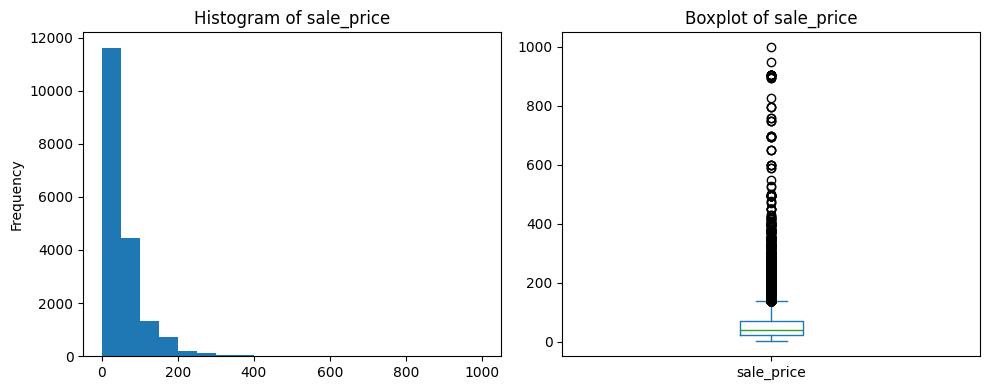

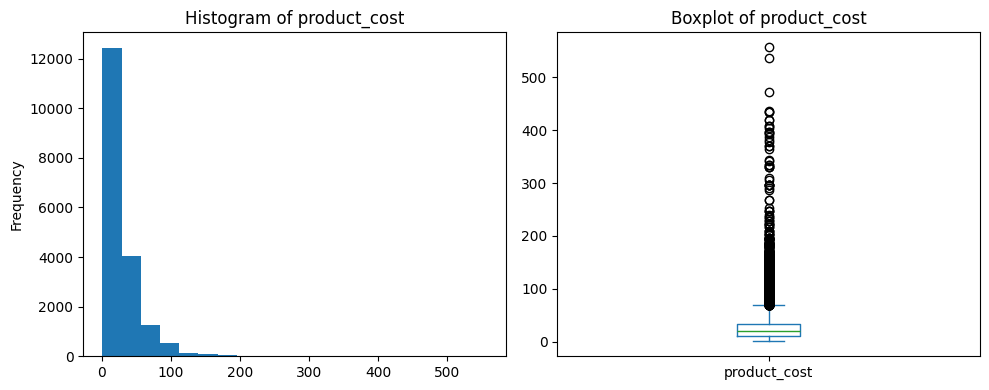

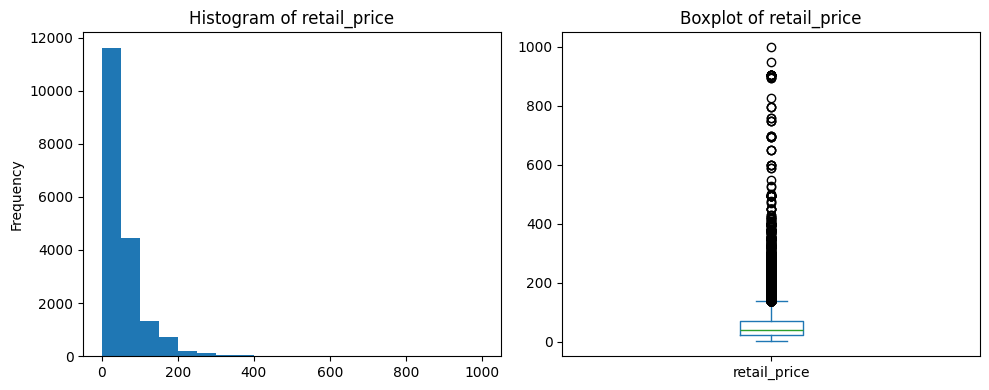

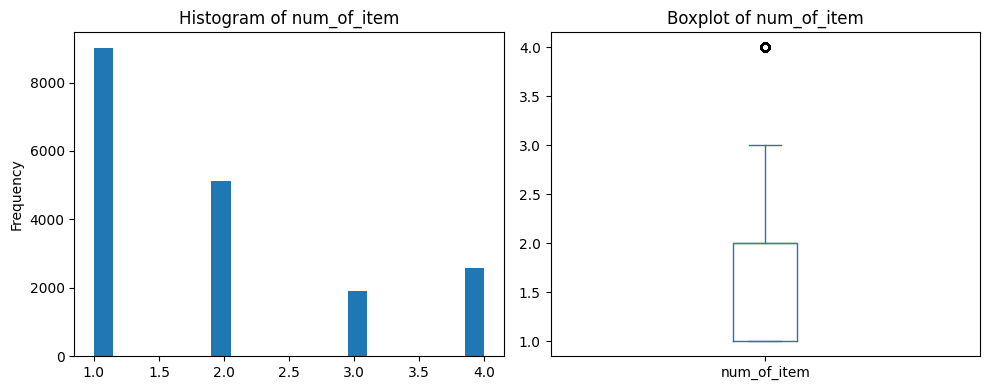

In [ ]:
# Membuat histogram dan boxplot
for cols in num_cols.columns:
    fig, ax = plt.subplots(ncols=2,figsize=(10,4))
    num_cols[cols].plot(kind='hist', bins=20, ax=ax[0], title=f'Histogram of {cols}')
    num_cols[cols].plot(kind='box', ax=ax[1], title=f'Boxplot of {cols}')
    plt.tight_layout()
    plt.show()

### 5.3.2 Correlation Analysis

# 6. Feature Engineering

## Feature creation total_cost

In [ ]:
# Membuat kolom total_cost berdasarkan product_cost dan num_of_item
df2['total_cost'] = (df2['product_cost'] * df2['num_of_item']).round(2)

## 6.2 Feature creation total_sales

In [ ]:
# Membuat kolom total_sales berdasarkan sale_price dan num_of_item
df2['total_sales'] = (df2['sale_price'] * df2['num_of_item']).round(2)

## 6.3 Feature creation net_profit

In [ ]:
# Membuat kolom net_profit berdasarkan total_sales dan total_cost
df2['net_profit'] = df2['total_sales'] - df2['total_cost'] 

# 7. Visualization and Correlation Analysis

In [ ]:
# membuat function untuk melakukan groupby berdasarkan order yang berstatus Cancelled dan Returned dan melakukan visualisasi
def plot_top_groups_by_status(df, group_column, status_columns=['Cancelled', 'Returned']):

    # Group berdasarkan column dan 'order_status', kemudian hitung jumlahnya
    grouped = df2.groupby([group_column, 'order_status']).size().unstack()

    # Menghitung total order_status group
    status_total = grouped[status_columns].sum(axis=1)

    # Ambil 10 terbesar berdasarkan total order_status
    top_10_groups = status_total.nlargest(10).index

    # Visualisasi
    ax = grouped.loc[top_10_groups].plot(kind='bar', stacked=True, figsize=(10, 6))
    
    # Label dan judul
    ax.set_title(f'Top 10 {group_column.capitalize()} Based on {", ".join(status_columns)} Orders')
    ax.set_xlabel(group_column.capitalize())
    ax.set_ylabel('Order Count')
    plt.xticks(rotation=45)
    
    # Tampilkan grafik
    plt.show()

## 7.1 Distribution of Order Item Status

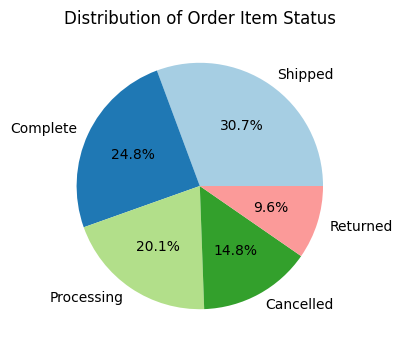

In [58]:
# Menghitung jumlah pada setiap value di kolom order_item_status
status_counts = df2['order_item_status'].value_counts()

# Untuk pie chart
plt.figure(figsize=(4, 4))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=00, colors=plt.cm.Paired.colors)

# Menambahkan judul
plt.title('Distribution of Order Item Status')

# Menampilkan chart
plt.show()

## 7.2 Item Related

### 7.2.1 Correlation between order_status and sale_price

In [ ]:
# Menghitung korelasi spearman antara order_status dan sale_price
corr, p_value = kendalltau(df2['order_status'], df2['sale_price'])

# Menampilkan hasil
print(f"Korelasi kendall: {corr}")
print(f"p value: {p_value}")

Korelasi spearman: -0.0023866648570625413
p value: 0.6592015756503496


- Karena order_status merupakan kolom categorical dan sale_price adalah kolom numerical dengan distribusi data yang tidak normal, maka digunakan uji korelasi kendall untuk mengukur hubungan antara dua variabel tersebut.
- Tidak ada hubungan yang signifikan antara order_status dan sale_price berdasarkan perhitungan korelasi spearman, karena nilai korelasi sangat rendah yaitu -0.002 dan p-value lebih besar dari 0.05.

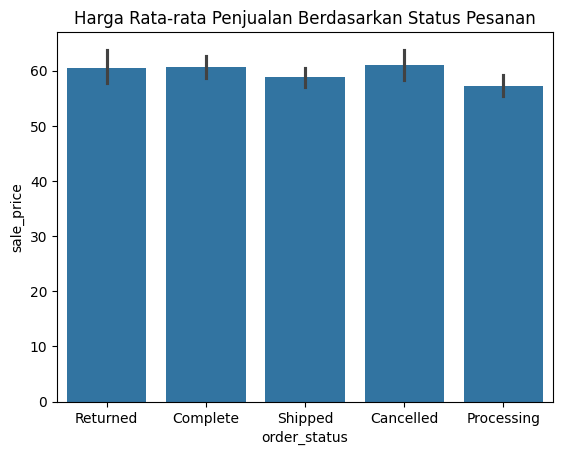

In [ ]:
# Visualisasi barplot untuk order_status dan sale_price berdasarkan rata2
sns.barplot(x='order_status', y='sale_price', data=df2, estimator='mean')
plt.title('Harga Rata-rata Penjualan Berdasarkan Status Pesanan')
plt.show()

### 7.2.2 Correlation between order_status and num_of_item

In [ ]:
# Melakukan uji Kendall Tau
tau, p_value = stats.kendalltau(df2['order_status'], df2['num_of_item'])

# Melihat hasil
print(f"tau-correlation: {tau:.2f}, p-value: {p_value}")

tau-correlation: 0.01, p-value: 0.030373264636538302


Meskipun terdapat hubungan dan signifikan antara order_status dan num_of_item, tetapi hubungan tersebut sangat lemah karena nilai tau adalah 0.01

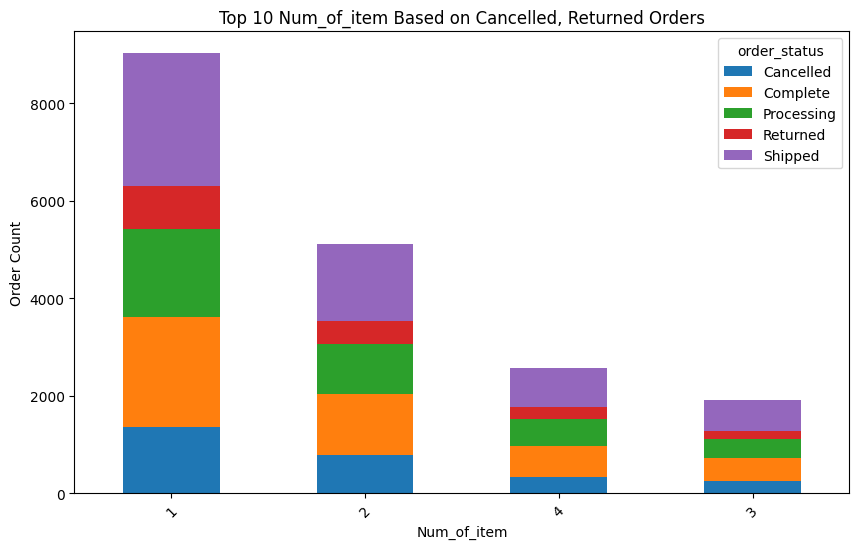

In [ ]:
# Menampilkan visualisasi stackbar
plot_top_groups_by_status(df2, 'num_of_item')

### 7.2.3 Correlation between order_status and product_category

In [ ]:
# Uji Chi-Square
contingency_table = pd.crosstab(df2['product_category'], df2['order_status'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 112.6883888374989
p-value: 0.1818006305013177


Walaupun nilai uji chi-square cukup besar, yaitu 112.69, tetapi p-value nya lebih besar dari 0.05 sehingga tidak ada bukti bahwa product_category dan order_status berhubungan secara signifikan.

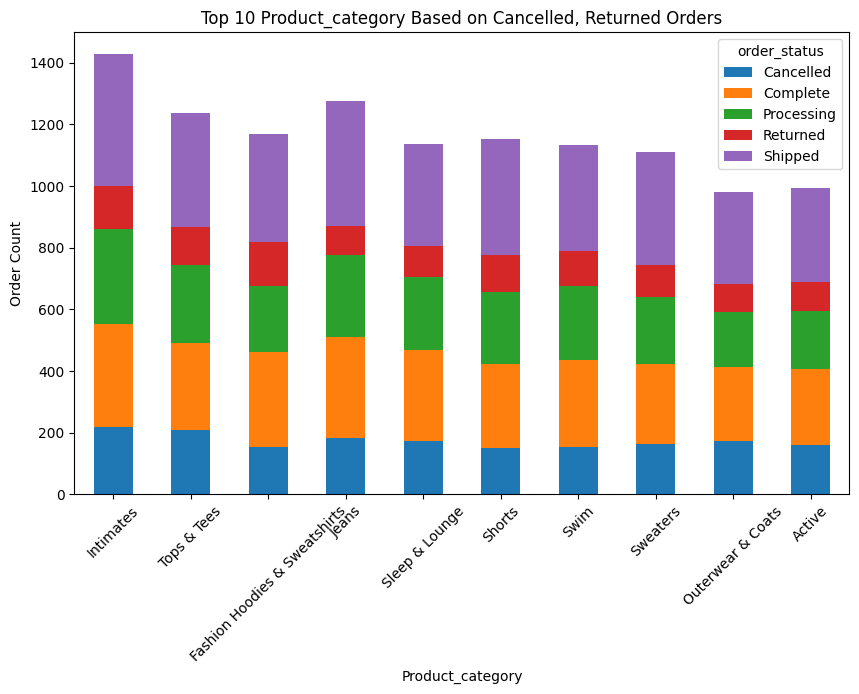

In [ ]:
# Menampilkan visualisasi stackbar
plot_top_groups_by_status(df2, 'product_category')

### 7.2.4 Correlation between order_status and brand

In [70]:
# Uji Chi-Square
contingency_table = pd.crosstab(df2['brand'], df2['order_status'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 8396.868889830243
p-value: 0.20722245496547118


Meskipun nilai statistik chi-squarenya besar, tetapi nilai p-value yang lebih besar dari 0.05 menunjukkan tidak ada bukti bahwa adan hubungan yang signifikan antara brand dan order_status

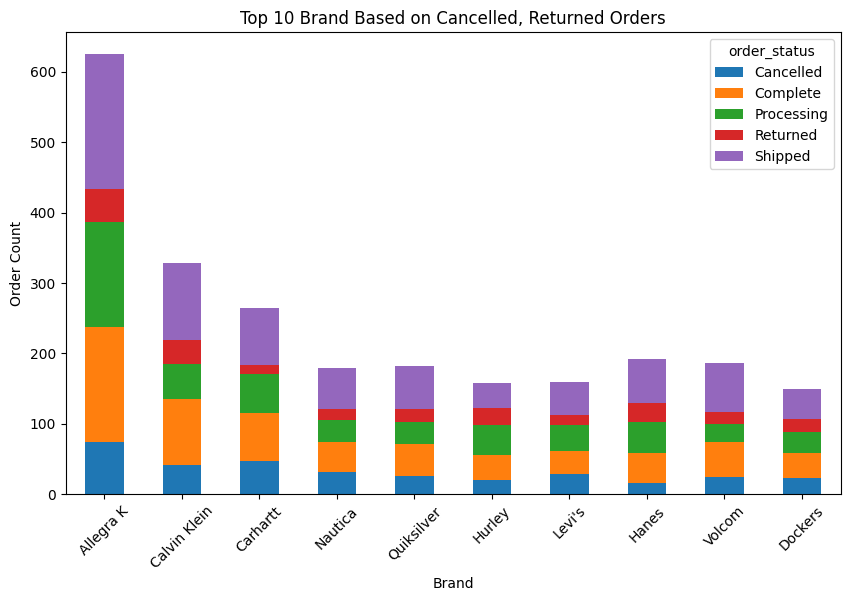

In [ ]:
# Menampilkan visualisasi stackbar
plot_top_groups_by_status(df2, 'brand')

### 7.2.5 Correlation between order_status and department

In [71]:
# Uji Chi-Square
contingency_table = pd.crosstab(df2['department'], df2['order_status'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 2.535058635228304
p-value: 0.6383691964391109


Nilai chi-square tidak terlalu besar, dan dengan nilai p-value yang lebih besar dari 0.05 hal ini menunjukkan bahwa tidak ada hubungan yang signifikan antara department dan order_status.

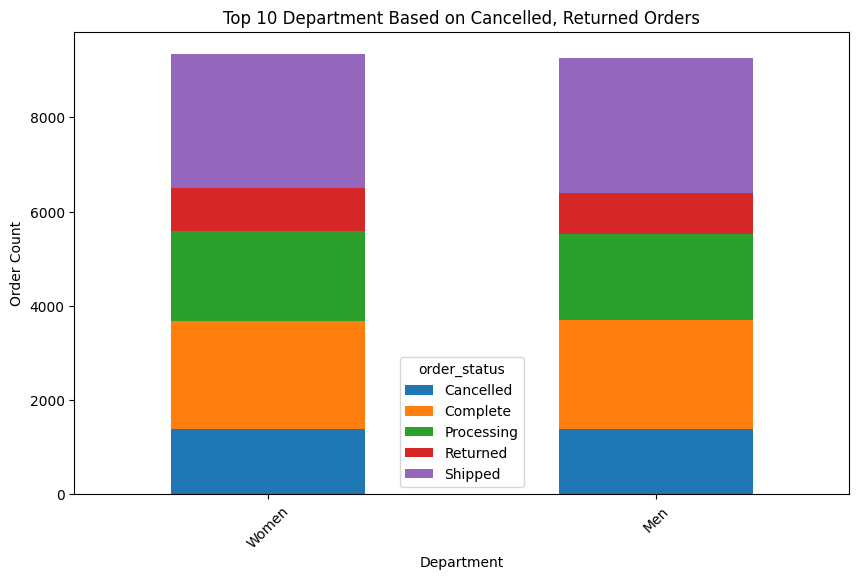

In [ ]:
# Menampilkan visualisasi stackbar
plot_top_groups_by_status(df2, 'department')

## 7.3 Time (Months)

In [ ]:
# Mengekstrak bulan pada kolom order_created
df2['month_year'] = df2['order_created'].dt.to_period('M')

# Groupby data berdasarkan month_year dan order_status
all_status_trend = df2.groupby(['month_year', 'order_status']).size().unstack(fill_value=0)
all_status_trend = all_status_trend.sort_index()

all_status_trend

order_status,Cancelled,Complete,Processing,Returned,Shipped
month_year,,,,,
2023-01,418,694,572,249,949
2023-02,402,678,532,291,835
2023-03,481,803,614,301,950
2023-04,459,759,681,269,957
2023-05,557,827,682,358,1015
2023-06,438,850,664,324,1000


## 7.4 Location

In [72]:
# Uji Chi-Square
contingency_table = pd.crosstab(df2['distribution_center_name'], df2['order_status'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Menampilkan hasil
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 28.637927100431284
p-value: 0.8037037044258198


Nilai chi-square tidak terlalu besar, dan dengan nilai p-value yang lebih besar dari 0.05 hal ini menunjukkan bahwa tidak ada hubungan yang signifikan antara distribution_center_name dan order_status.

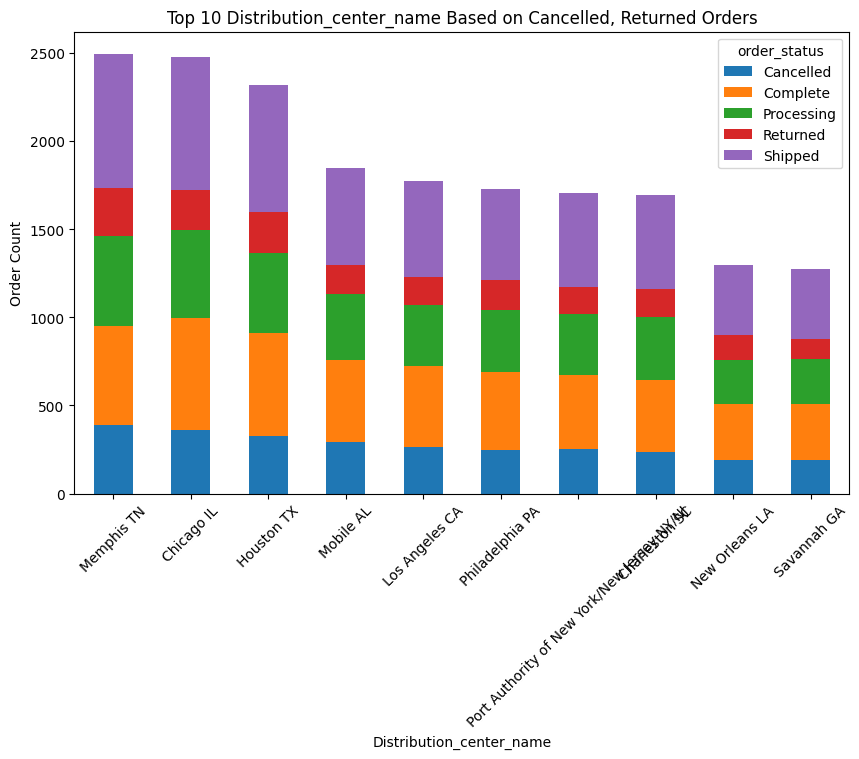

In [ ]:
# Menampilkan visualisasi stackbar
plot_top_groups_by_status(df2, 'distribution_center_name')

# 8. Other Visualization

## 8.1 Line chart jumlah order

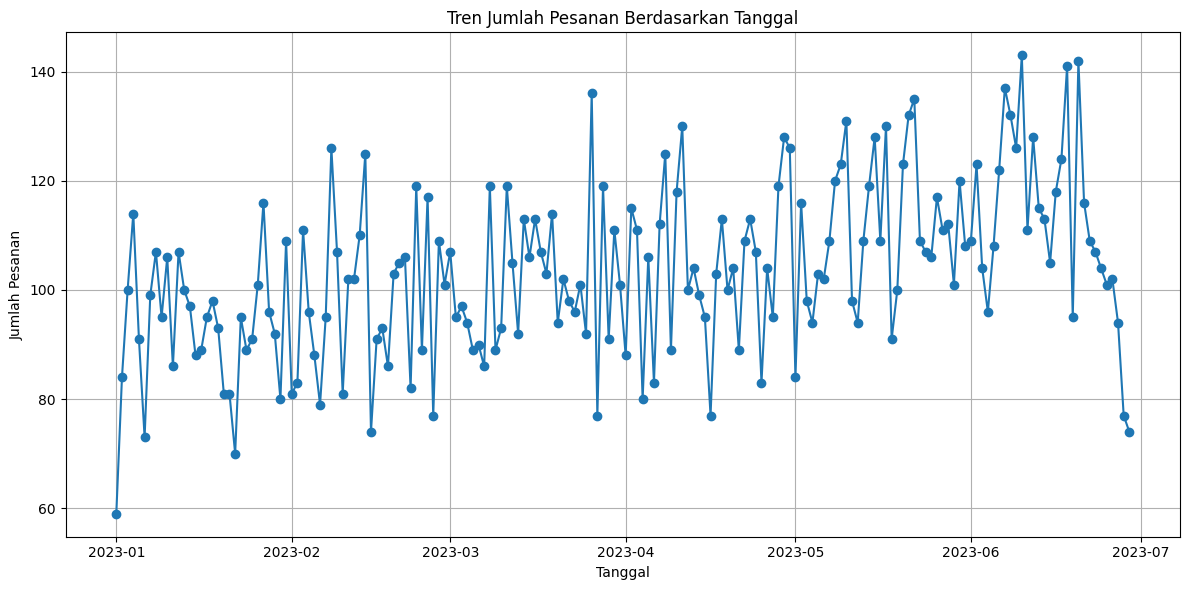

In [ ]:
# membuat time series untuk jumlah order
orders_by_day = df2['order_created'].dt.date.value_counts().sort_index()

# Membuat line chart
plt.figure(figsize=(12, 6))
orders_by_day.plot(kind='line', marker='o')
plt.title('Tren Jumlah Pesanan Berdasarkan Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Pesanan')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8.2 Top kategori produk berdasarkan jumlah order

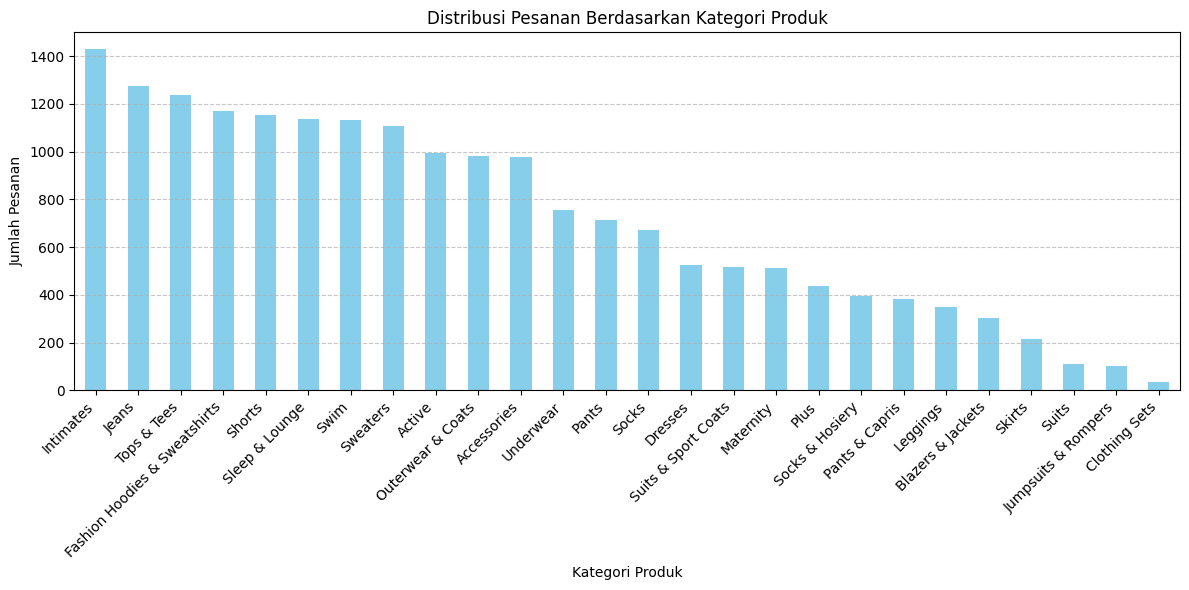

In [ ]:
# Menghitung jumlah per value pada kolom product_vategory
category_counts = df2['product_category'].value_counts()

# Visualisasi bar chart
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue')

# Membuat judul dan label
plt.title('Distribusi Pesanan Berdasarkan Kategori Produk')
plt.xlabel('Kategori Produk')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8.3 Distribusi jumlah order berdasarkan gender

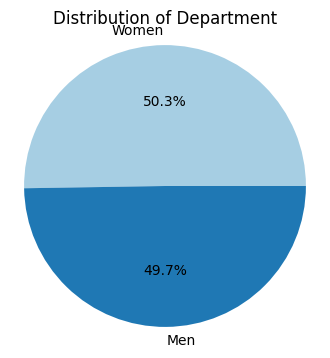

In [ ]:
# Menghitung jumlah per value pada kolom department
status_counts = df2['department'].value_counts()

# Membuat pie chart
plt.figure(figsize=(4, 4))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=00, colors=plt.cm.Paired.colors)

# Menambahkan judul
plt.title('Distribution of Department')
plt.axis('equal')
plt.show()

## 8.4 Top 15 brand

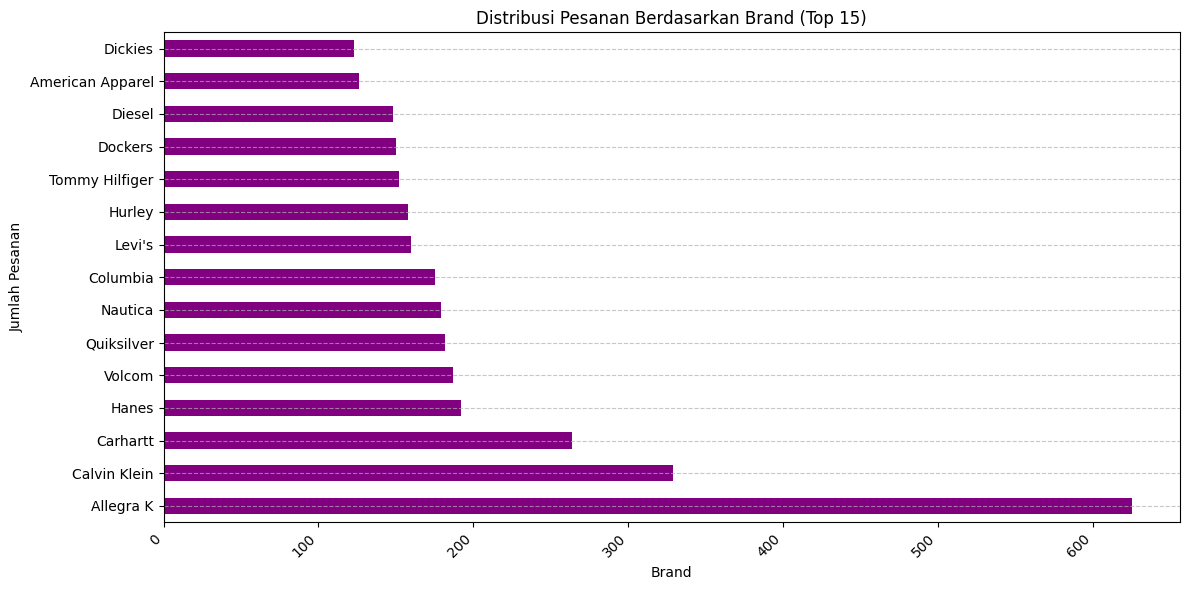

In [ ]:
# Menghitung jumlah per value pada kolom brand_counts dan ambil hanya 15 terbanyak
brand_counts = df2['brand'].value_counts().head(15)

# Plot distribution by brand (bar chart)
plt.figure(figsize=(12, 6))
brand_counts.plot(kind='barh', color='purple')
plt.title('Distribusi Pesanan Berdasarkan Brand (Top 15)')
plt.xlabel('Brand')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8.5 Line chart trend untuk brand

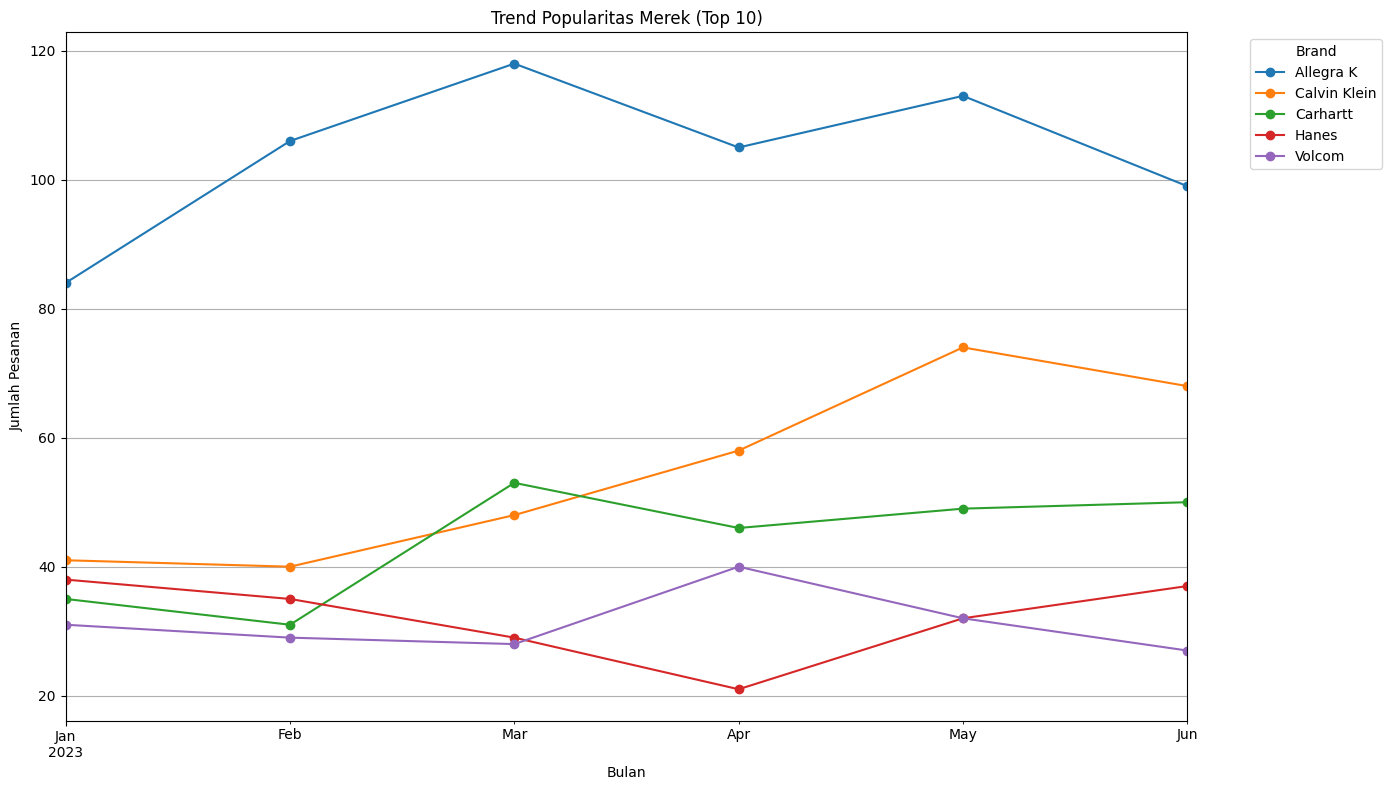

In [ ]:
# Groupby bulan dan brand
df2['order_date'] = df2['order_created'].dt.to_period('M')
top_brands = df2['brand'].value_counts().head(5).index
brand_trends = df2[df2['brand'].isin(top_brands)].groupby(['order_date', 'brand']).size().unstack().fillna(0)

# Plot line chart untuk melihat tren pada brand
plt.figure(figsize=(14, 8))
brand_trends.plot(ax=plt.gca(), marker='o')
plt.title('Trend Popularitas Merek (Top 10)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pesanan')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8.6 Line chart trend untuk product_category

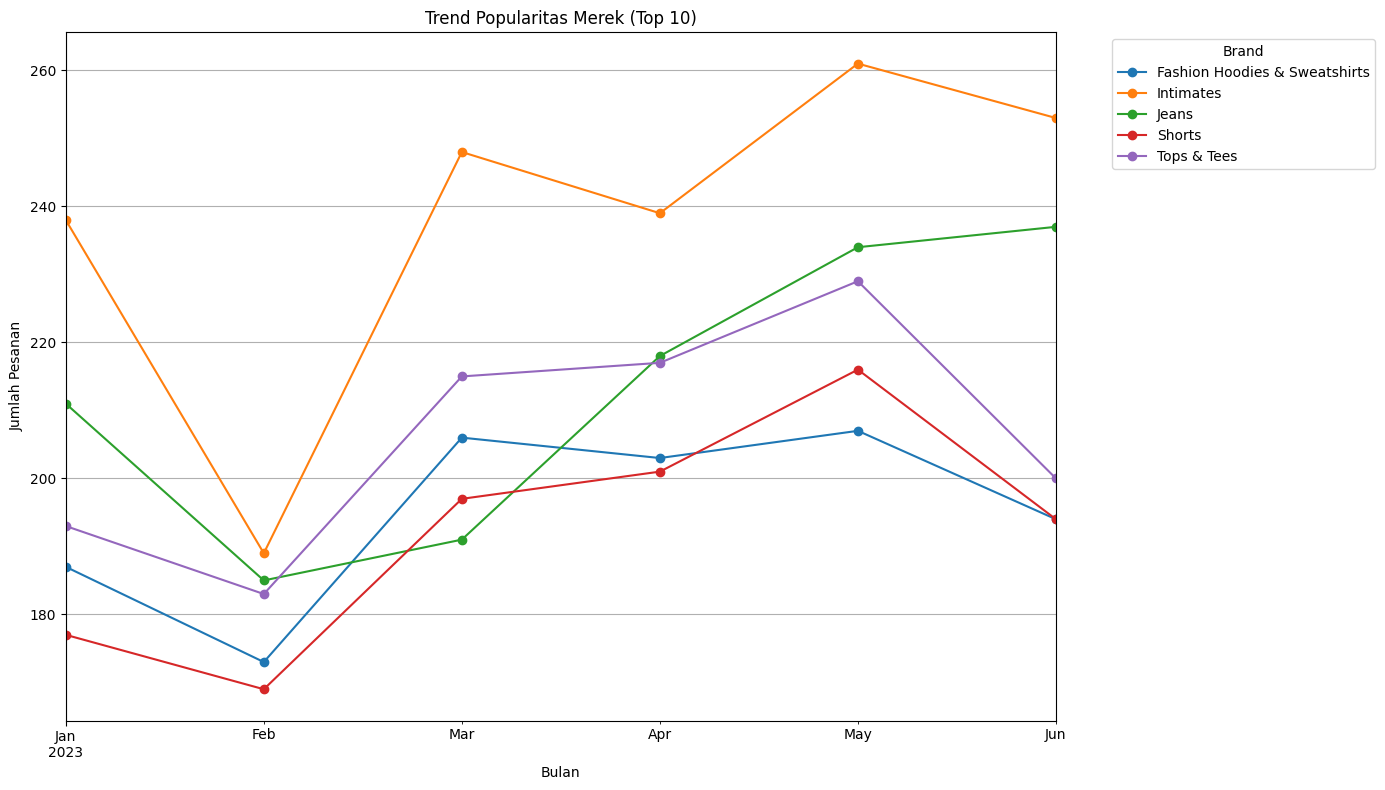

In [ ]:
# Groupby bulan dan product_category
top_brands = df2['product_category'].value_counts().head(5).index
brand_trends = df2[df2['product_category'].isin(top_brands)].groupby(['order_date', 'product_category']).size().unstack().fillna(0)

# Plot line chart untuk melihat tren pada product_category
plt.figure(figsize=(14, 8))
brand_trends.plot(ax=plt.gca(), marker='o')
plt.title('Trend Popularitas Merek (Top 10)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pesanan')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8.7 Top 10 distribution_center_name berdasarkan jumlah order

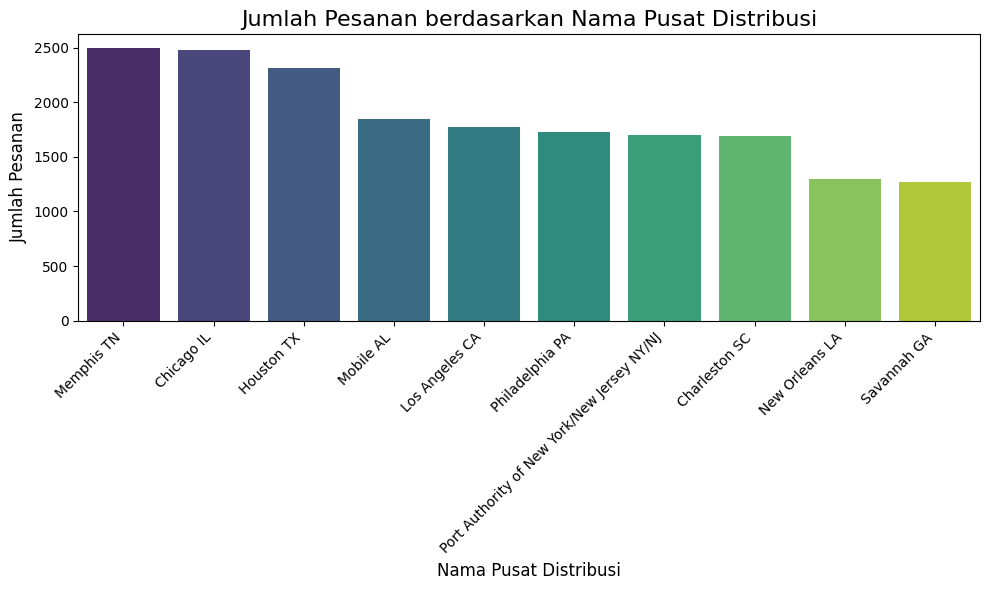

In [ ]:
# Menghitung jumlah value pada kolom distribution_center_name
distribution_counts = df2['distribution_center_name'].value_counts()

# Membuat bar chat
plt.figure(figsize=(10, 6))
sns.barplot(x=distribution_counts.index, y=distribution_counts.values, palette='viridis')

# Menambahkan judul dan label
plt.title('Jumlah Pesanan berdasarkan Nama Pusat Distribusi', fontsize=16)
plt.xlabel('Nama Pusat Distribusi', fontsize=12)
plt.ylabel('Jumlah Pesanan', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Drop kolom yang tidak digunakan
df2.drop(['month_year', 'order_date','brand_original'], axis=1, inplace=True)

In [ ]:
# Simpan data yang sudah clean ke csv
df2.to_csv('data_clean.csv')